# Computer Vision Course (2024 Spring) Homework 2

---

## Problem 4. Image retrieval
We have collected 25 photos of the buildings in SJTU as a database. Given a query image, please find the same buildings as the query image from the database. Your algorithm should use local image features. (50 points)

- Recommended environment:
  - `python==3.8`, `opencv-python>=4.3.0`, `numpy`, `matplotlib`.

- Input data: 
  - Query image: `data/query.jpg`
  - Database: `data/1.jpg`, `data/2.jpg`, ..., `data/25.jpg`

- Hint:
  - Your answer will be graded based on both the performance of the algorithm (in Code blocks) and the completeness of the discussion (in Markdown blocks or PDF report). Therefore, please preserve the output of each step in this notebook!
  - You can use any `cv2` function as long as you clearly explain how it works in your algorithm.
  - Useful tools: SIFT feature descriptor, bag-of-words model, k-nearest neighbors algorithm, ... (not limited)

- Grading standards:
  - Local image feature detection, description and visualization. (20 points)
  - Feature matching and visualization. (10 points)
  - Scoring the matching results and retrieving the similar photos. (10 points)
  - Evaluation and discussion of the results. (10 points)

- Bonus:
  - We provide another 3 photos as hard cases, in the folder `data.hard/`. If your algorithm works well for these images, each correct retrieval is worth another 2 points (up to a maximum of 100 points in this homework).

---

### Step 1: SIFT Feature Point Extraction
Extract key points and corresponding descriptors from images using the SIFT algorithm. These descriptors represent local features in the image and have rotation and scale invariance.

In [2]:
import cv2
import numpy as np

descriptors = []
for i in range(1,26):
    # read img
    img = cv2.imread("data/"+str(i)+".jpg")
    # convert to gray
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # construct the sift function
    sift = cv2.SIFT_create()
    # find keypoints
    kp = sift.detect(gray, None)
    # Use key points to find sift feature vectors
    kp, des = sift.compute(gray, kp)
    descriptors.append(des)

### Step 2: K-means clustering
Put all the features obtained from image processing together and perform K-means clustering.

In [3]:
from sklearn.cluster import KMeans
import pickle

tmp = descriptors[0]
for i in descriptors[1:]:
    tmp = np.vstack((tmp,i))

# train model
estimator = KMeans(n_clusters=100, max_iter=300, n_init='auto')
estimator.fit(tmp)

# save model
with open('kmeans.pkl', 'wb') as file:
    pickle.dump(estimator, file)

### Step 3: Obtain the BOF vector
This step uses the dictionary obtained in the previous step to determine which words each image's features belong to, and obtains a word frequency vector of the same dimension as the number of words in the dictionary. This is the BOF vector.

In [4]:
import pickle
import cv2
import numpy as np

# load model
with open('kmeans.pkl', 'rb') as file:
    estimator = pickle.load(file)

cluster_num = len(estimator.cluster_centers_)
pic_num = len(descriptors)
label_pred = estimator.labels_
TF = np.zeros((pic_num, cluster_num))
IDF = np.zeros(cluster_num)
count = 0
for i in range(pic_num):
    for j in range(count, count+len(descriptors[i])):
        TF[i][label_pred[j]] += 1
        IDF[label_pred[j]] += 1
    count = j

IDF = 1000/IDF
BOF = np.zeros((pic_num, cluster_num))
for i in range(pic_num):
    for j in range(cluster_num):
        BOF[i][j]= TF[i][j]**2*IDF[j]/len(descriptors[i])


### Step 4: Similarity sorting
Extract feature descriptors from the test dataset and sort the test machine images by similarity.

[ 2  0  1 15  4 14 19 24  5 10 21 16 22  3 13 18  7  8  9 11 20 12 23 17
  6]


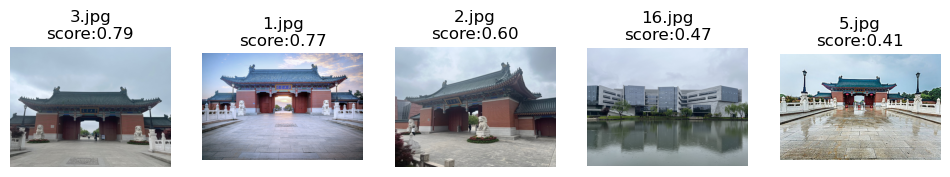

In [31]:
# extract key points
test_img = cv2.imread("data.hard/28.jpg")
gray = cv2.cvtColor(test_img, cv2.COLOR_BGR2GRAY)
sift = cv2.SIFT_create()
kp = sift.detect(gray, None)
kp, des = sift.compute(gray, kp)

with open('kmeans.pkl', 'rb') as file:
    estimator = pickle.load(file)
# similarity sorting
label = estimator.predict(des)

feature = np.zeros(cluster_num)
for i in label:
    feature[i] += 1

for i in range(cluster_num):
    feature[i] = feature[i]**2*IDF[i]/len(label)

def dis(v1, v2):
    return np.dot(v1,v2)/(np.linalg.norm(v1)*np.linalg.norm(v2))

dis_li = [dis(feature, f) for f in BOF]
print(np.argsort(dis_li)[::-1])

import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12,3))
for i in range(5):
    index = np.argsort(dis_li)[::-1][i]
    PicsNames = "data/"+str(index+1)+".jpg"
    img = cv2.imread(PicsNames)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)  
    plt.subplot(1,5,i+1)
    plt.axis("off")
    plt.imshow(img)
    plt.title(str(index+1)+".jpg\n"+"score:"+"%.2f"%dis_li[index])
plt.show()
fig.savefig("result.jpg")